# 03. PyTorch Computer Vision

## 0. Computer vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchivision.datasets` - datasets and data loading functions for computer vision here
* `torchvision.models` - pretrained computer vision models that you can use for your own projects
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitables for use with an ML model
* `torch.utils.data.Dataset` - base dataset class for PyTorch
* `torch.utils.data.DataLoader` - creates a Python iterable over a dataset

In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
print(torchvision.__version__)

2.2.1
0.17.1


## 1. Getting a dataset

The dataset we'll be using is FashionMNIST from `torchvision.datasets` - Zalando said that the MNIST number dataset was too easy and boring, so they made a fashion dataset instead. It's a dataset of 28x28 grayscale images of clothes, with 10 classes.

In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # data directory (where to download data too)
    train=True, # do we want the training data set
    download=True, # should we download the data
    transform=ToTensor(), # convert the data to a tensor
    target_transform=None # the transformation to apply to the target
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

### 1.1 Check input and output shapes of data

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
train_data[0][0].shape, train_data[0][1]

(torch.Size([1, 28, 28]), 9)

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 1.2 Visualizing our data

(-0.5, 27.5, 27.5, -0.5)

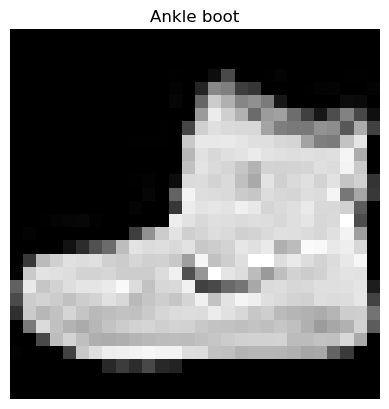

In [8]:
# Display the first image
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')

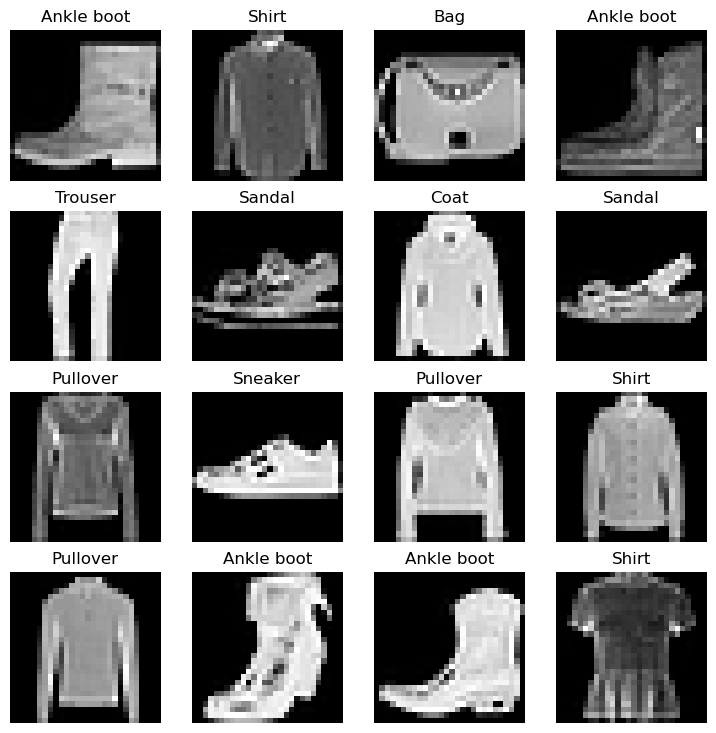

In [9]:
# Random images go
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    img_idx = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[img_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')

It's worth thinking, whether the images could be modelled with pure linear lines. If not, we should use non-linear models.

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why?

1. It is more computationally efficient, as in, computing hardware may not be able to look (store in memory) at 60.000 images (or even more!) at once. So we break it down to smaller chunks. Here we'll use 32 images.
2. It gives our neural network more chances to update it's gradients per epoch.

In [10]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1b49d23df90>,
 <torch.utils.data.dataloader.DataLoader at 0x1b4c1274290>)

In [11]:
print(f'Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [12]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


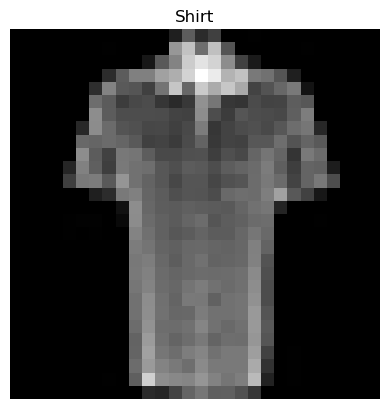

In [13]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis('off')
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [14]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform roward pass

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [15]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # 28 * 28
                              hidden_units=10,
                              output_shape=len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
dummy_x = torch.rand([1, 1, 28, 28])
print(model_0(dummy_x))

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)


### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem with balanced classes, our evaluation metric will be accuracy.

In [18]:
import requests
from pathlib import Path

# Download helper functions from GitHub (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists. Skipping download.")
else:
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    get_url = requests.get(url)
    with open("helper_functions.py", "w") as f:
        f.write(get_url.text)

helper_functions.py already exists. Skipping download.


In [19]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Models' performace (loss and accuracy values etc.)
2. How fast it runs

In [20]:
from timeit import default_timer as timer

In [21]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""

    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [22]:
start_time = timer()

end_time = timer()
print_train_time(start_time,end_time)

Train time on None: 0.000 seconds


2.4500011932104826e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out the results.
5. Time it all!

In [23]:
# Import tqdm for progress bar!
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start = timer()

# Set the number of epochs (we'll keep this small for faster training)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(1, epochs+1)):
    print(f"Epoch: {epoch}\n-----")

    ### Training
    train_loss = 0

    # Add a loop to loop through the training batches
    model_0.train()
    for batch, (X, y) in enumerate(train_dataloader):
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0

    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (per batch) and accuracy
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1).squeeze())

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)

    # Print out what's happening
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end = timer()

total_train_time_model_0 = print_train_time(train_time_start, train_time_end, str(next(model_0.parameters()).device))
print(total_train_time_model_0)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
-----
Looked at 0/60000 samples.


Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 3
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 35.305 seconds
35.3048236000177


## 4. Make predictions and get Model 0 results

In [24]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):

            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # Scale loss and acc to find the average
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class,
            "model_loss": loss.item(),
            "model_acc": acc}

In [25]:
torch.manual_seed(42)

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device="cpu")

print(model_0_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4766390025615692, 'model_acc': 83.42651757188499}


## 5. Setup device agnostic-code (for using a GPU if there is one)

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [27]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [28]:
model_1 = FashionMNISTModelV1(input_shape=28*28,
                              output_shape=len(class_names),
                              hidden_units=10
                              ).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [29]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops
finally :D

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [30]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training step with model trying to learn on data_loader"""

    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and acc (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1)) # go from logits -> predictions labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Normalize the loss and acc by length of dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Print out the results
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")

In [31]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Performs a test step on model going over data_loader"""

    test_loss, test_acc = 0, 0

    # Put model into eval mode
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            # Put data on target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss (per batch) and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        # Normalize the loss and acc by length of dataloader
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    
        # Print out the results
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [32]:
# Import tqdm for progress bar!
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start = timer()

# Set the number of epochs (we'll keep this small for faster training)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(1, epochs+1)):
    print(f"Epoch: {epoch}\n-----")

    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

# Calculate training time
train_time_end = timer()

total_train_time_model_1 = print_train_time(train_time_start, train_time_end, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
-----
Train loss: 1.11456 | Train accuracy: 58.46%

Test loss: 0.96320 | Test accuracy: 63.41%

Epoch: 2
-----
Train loss: 0.90905 | Train accuracy: 64.87%

Test loss: 0.74544 | Test accuracy: 72.61%

Epoch: 3
-----
Train loss: 0.59508 | Train accuracy: 78.25%

Test loss: 0.49708 | Test accuracy: 82.77%

Train time on cuda: 43.328 seconds


>**Note:** Sometimes, depending on the data/hardware the model might train faster on CPU than GPU.
>
>Why?
>
>1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits of using the GPU (parralel processing).
>2. The hardware might have a better CPU in terms of compute performance than the GPU (but it's rare tho).

In [33]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

print(model_1_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.4970788359642029, 'model_acc': 82.76757188498402}


## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find their patterns in visual data.

Fun website: https://poloclub.github.io/cnn-explainer/

We're going to use TinyVGG architecture taken from the website above. The fun thing about neural networks is that you can very often find a pre-built model that suits your needs.

In [34]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG model form CNN explainer website.
    """
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, # We need to calculate this one!
                      out_features=output_shape)
        )

    def forward(self, x, verbose=False):
        x = self.conv_block_1(x)
        if verbose:
            print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        if verbose:
            print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        if verbose:
            print(f"Output shape of classifier: {x.shape}")
        return x

In [35]:
image.shape

torch.Size([1, 28, 28])

In [36]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

### 7.1 Stepping through `nn.Conv2d()`

In [37]:
torch.manual_seed(42)

# Create a batch of dummy images with 3 color channels
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])


In [38]:
# Create a single conv2d lyer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 7.2 Stepping through `nn.MaxPool2d()`

In [39]:
test_image.shape

torch.Size([3, 64, 64])

In [40]:
# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the data through just the conv_layer
conv_output = conv_layer(test_image)
print(f"Shape after convolution: {conv_output.shape}")

# Pass data through the max pool layer
max_pool_output = max_pool_layer(conv_output)
print(f"Shape after convolution and maxpool: {max_pool_output.shape}")


Shape after convolution: torch.Size([10, 62, 62])
Shape after convolution and maxpool: torch.Size([10, 31, 31])


In [41]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
random_tensor

tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

In [42]:
# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the tensor through the layer
max_pool_output = max_pool_layer(random_tensor)
print(f"Max pool tensor:\n{max_pool_output}")
print(f"Max pool tensor shape:{max_pool_output.shape}")

Max pool tensor:
tensor([[[[0.3367]]]])
Max pool tensor shape:torch.Size([1, 1, 1, 1])


In [43]:
image, label = train_data[0]
print(image.shape)

torch.Size([1, 28, 28])


### 7.3 Finding the number of features before the fully connected layer

To find the number of features before the fully connected layer, we can use some formula, but that's hard, long and booooring.
Instead we can just print the shape of our data after it passes through every layer, and then just multiply the dimensions together :D

In [44]:
try:
    model_2.eval()
    with torch.inference_mode():
        image = image.to(device)
        output = model_2(image.unsqueeze(0), verbose=True)
except Exception as e:
    print(e)

Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])


In [45]:
output

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0')

### 7.4 Setup an optimizer and loss function for the CNN

In [46]:
# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.5 Training and testing `model_2`

In [47]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer

train_time_start = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(1, epochs+1)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end = timer()
total_train_time_model_2 = print_train_time(train_time_start, train_time_end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
----------
Train loss: 0.59367 | Train accuracy: 78.53%

Test loss: 0.39976 | Test accuracy: 85.81%

Epoch: 2
----------
Train loss: 0.35751 | Train accuracy: 87.19%

Test loss: 0.34760 | Test accuracy: 87.38%

Epoch: 3
----------
Train loss: 0.32056 | Train accuracy: 88.48%

Test loss: 0.32552 | Test accuracy: 88.36%

Train time on cuda: 48.392 seconds


In [48]:
# Get model_2 results
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3255165219306946,
 'model_acc': 88.35862619808307}

## 8. Compare model results and training time

In [49]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])

In [50]:
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.497079,82.767572
2,FashionMNISTModelV2,0.325517,88.358626


In [51]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,35.304824
1,FashionMNISTModelV1,0.497079,82.767572,43.327890
2,FashionMNISTModelV2,0.325517,88.358626,48.391560


Text(0, 0.5, 'model')

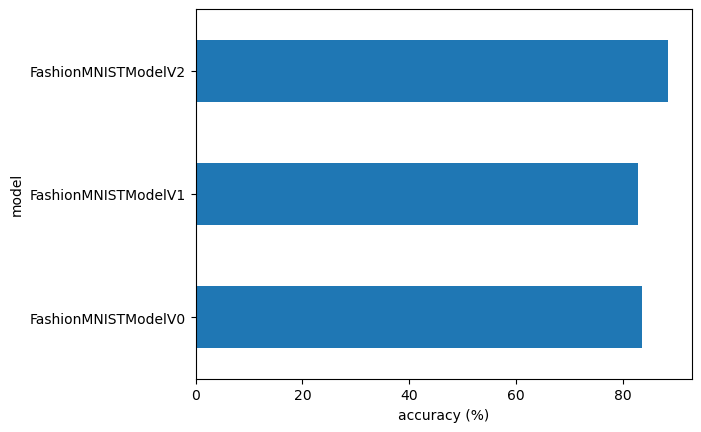

In [52]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 9. Make and evaluate random prediction with best model

In [53]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []

    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for furter calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [54]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

    # View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Dress')

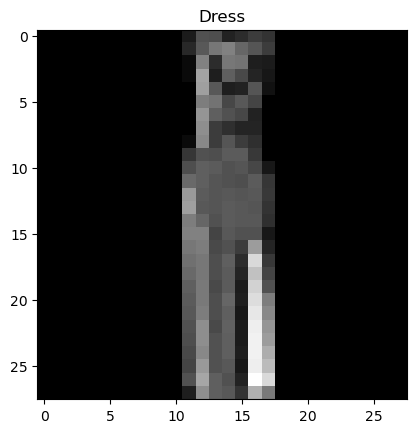

In [55]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [56]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[3.1778e-03, 4.5017e-01, 2.1081e-04, 5.3594e-01, 4.2124e-03, 7.8697e-04,
         1.2743e-03, 1.1759e-03, 9.8279e-04, 2.0697e-03],
        [1.9399e-09, 8.5524e-10, 5.0854e-10, 2.1382e-09, 1.7852e-08, 1.8356e-06,
         3.4723e-07, 6.9494e-08, 1.2130e-06, 1.0000e+00]])

In [57]:
# Convert prediction probabilites to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 9, 5, 0, 4, 7, 8, 1, 3])

In [58]:
test_labels

[3, 9, 5, 0, 4, 7, 8, 1, 3]

Text(0.5, 1.0, 'Sandal')

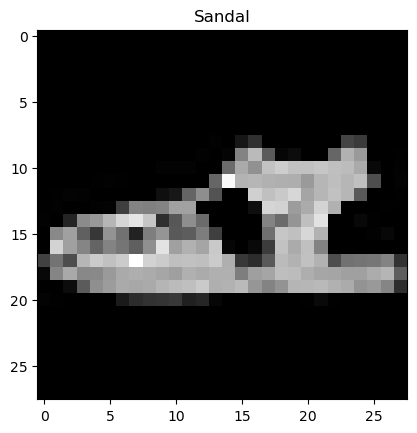

In [59]:
plt.imshow(test_samples[2].squeeze(), cmap="gray")
plt.title(class_names[test_labels[2]])

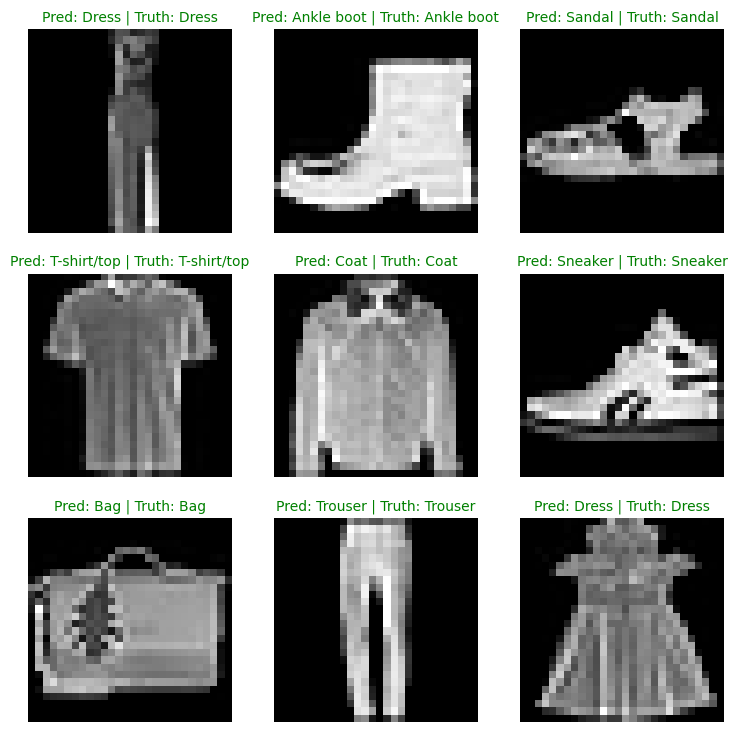

In [60]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    
    # Find the prediction (in text form)
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality between pred and truth and change color of title text
    color = "g" if pred_label == truth_label else "r"

    plt.title(title_text, fontsize=10, c=color)
    plt.axis('off')

## 10. Making a confusion matrix for futher prediction evaluation

A confusion matrix is a way to evaluate your models visually.

1. Make predictions with our trained model on the test dataset.
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`.
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`.

In [66]:
# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and targets to target device
        X, y = X.to(device), y.to(device)

        # Do the forward pass
        y_logit = model_2(X)

        # Turn predictions from logits to prediction probabilities to prediction labels
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [68]:
import torchmetrics
import mlxtend

In [69]:
mlxtend.__version__

'0.23.1'

In [71]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare prediction sto targets

confmat = ConfusionMatrix(num_classes=len(class_names),
                          task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

In [72]:
confmat_tensor

tensor([[616,   5,  46,  76,  15,   0, 228,   0,  14,   0],
        [  5, 878,  10,  79,  20,   0,   7,   0,   1,   0],
        [ 10,   3, 787,  15,  96,   0,  81,   0,   8,   0],
        [ 23,  11,  33, 865,  33,   0,  30,   0,   5,   0],
        [ 10,   4, 121,  49, 707,   0, 102,   0,   7,   0],
        [  6,   4,   7,  13,   0, 810,   5,  60,  67,  28],
        [ 82,   5, 110,  66,  93,   1, 629,   0,  14,   0],
        [  0,   2,   1,   2,   0,  28,   0, 906,   6,  55],
        [ 12,   3,  10,  13,  15,   4,  24,   4, 914,   1],
        [  0,   0,   0,   4,   2,  17,   6,  79,  13, 879]])

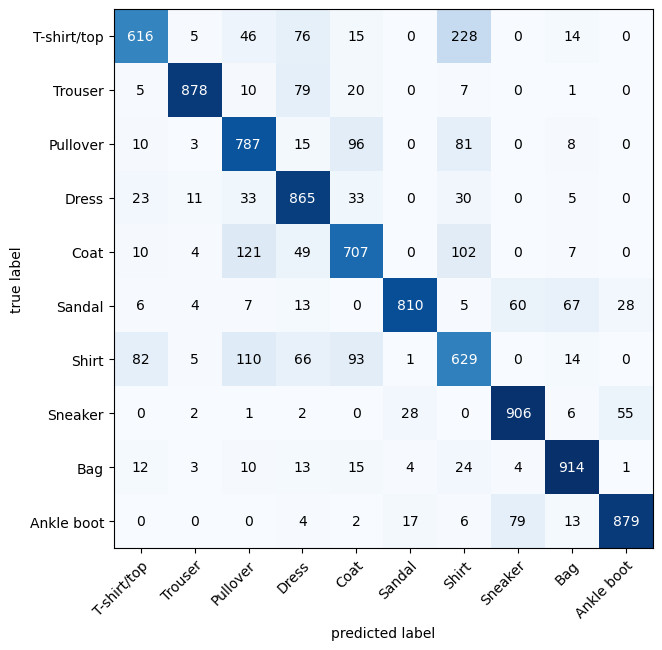

In [73]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib needs this one as numpy
    class_names=class_names,
    figsize=(10,7)
)

## 11. Save and load a model

Because I didn't do this one for a bit

In [74]:
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "03_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model state dict to {MODEL_SAVE_PATH}...")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model state dict to models\03_model_2.pth...


In [77]:
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [78]:
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [80]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3255165219306946,
 'model_acc': 88.35862619808307}

In [81]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3255165219306946,
 'model_acc': 88.35862619808307}

In [82]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]))

tensor(True)